In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc('figure', figsize=[8,8])  #set the default figure size

In [2]:
# This helper function will help you plot the decision boundary.
# It also shows the dataset.  If you add functions to your Naive
# Bayes classifier similar predict and fit in 
# sklearn.linear_model.LinearRegression (see the documentation)
# use should be able to use this without any modification.  See
# the example with LinearRegression below.

def plot_decision_boundary(predict_func, X, train_func=None, y=None):
    '''Plot decision boundary for predict_func on data X.
    
    If train_func and y are provided, first train the classifier.'''
    
    if train_func and y is not None:
        train_func(X, y)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))
    Z = predict_func(np.c_[np.around(xx.ravel()), 
                           np.around(yy.ravel())])
    Z = np.asarray(Z).reshape(xx.shape)

    _ = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.1)

    # Plot data points
    
    # Add small random noise so points with the same values
    # can be see differently
    X0 = X[:,0] + np.random.random(size=len(X))/5
    X1 = X[:,1] + np.random.random(size=len(X))/5

    # Plot the two classes separately with different colors/markers
    X0_class0 = X0[y==0] 
    X1_class0 = X1[y==0]
    _ = plt.scatter(X0_class0, X1_class0, marker='.', c='green')
    
    X0_class1 = X0[y==1] 
    X1_class1 = X1[y==1]
    _ = plt.scatter(X0_class1, X1_class1, marker='+', c='red')  

In [3]:
import pandas as pd

class NaiveBayes:
    
    def __init__(self):
        self.classes = [0,1]
        self.f0_cond_probs = pd.DataFrame()
        self.f1_cond_probs = pd.DataFrame()
        self.class_d = {}

    #def calculateProbDf(class_l, df):    
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : numpy array or sparse matrix of shape [n_samples,n_features]
            Training data
        y : numpy array of shape [n_samples, n_targets]
            Target values
        Returns
        -------
        """
        
        ind = list(range(len(X)))
        X_df = pd.DataFrame(X[:,0:2], index=[ind], columns=[0,1])
        y_df = pd.DataFrame(y[:,], index=[ind], columns=[0])
        y_df = y_df.rename(columns={0: 'class'})

        df = pd.concat([X_df,y_df], axis=1)
        class_l = self.classes
        
        f0_vals, f1_vals = self.getXYvalLists(df[[0,1]]) #get index vals for features
        
        f0_class_prob_df = self.createProbDf(class_l, f0_vals) #create empty df
        f1_class_prob_df = self.createProbDf(class_l, f1_vals)
        
        self.class_d = self.classValsDict(y_df, len(f0_vals), len(f1_vals))        
        
        class_counts_s = y_df['class'].value_counts() #get counts for class 0, 1

        for c in class_l:
            #get probs into df 
            for x in f0_vals:
                count = len(df[ (df[0] == x) & (df['class'] == c) ]) + 1
                f0_class_prob_df.ix[x,c]= count/(class_counts_s[c] + len(f0_vals) )
            for y in f1_vals:
                count = len(df[ (df[1] == y) & (df['class'] == c) ]) + 1 
                f1_class_prob_df.ix[y,c]= count/(class_counts_s[c] + len(f1_vals) )
        self.f0_cond_probs = f0_class_prob_df
        self.f1_cond_probs = f1_class_prob_df
        
        return self

  
    def getXYvalLists(self, df):
        return list(df[0].value_counts().index), list(df[1].value_counts().index)

    def createProbDf(self, cols, index_vals):
        return pd.DataFrame(columns=cols, index=index_vals)
 
    def predict(self, X):
        """Parameters
        ----------
        X : {array-like, sparse matrix}, shape = (n_samples, n_features)
            Samples.
        Returns
        -------
        C : array, shape = (n_samples,)
            Returns predicted values.
        """

        tmp = X[:, 0:2 ]
        
        ind = list(range(len(X)))

        f0_condprob_df = self.f0_cond_probs
        f1_condprob_df = self.f1_cond_probs

        class_dict = self.class_d
        
        preds = []
        
        for f0_val, f1_val in tmp:
        
            if f0_val in f0_condprob_df.index:
                pf0_1 = f0_condprob_df.ix[f0_val][1]
                pf0_0 = f0_condprob_df.ix[f0_val][0]
            else:
                pf0_1 = 1/class_dict['f1_smooth']
                pf0_0 = 1/class_dict['f0_smooth']
            
            if f1_val in f1_condprob_df.index:
                pf1_1 = f1_condprob_df.ix[f1_val][1]
                pf1_0 = f1_condprob_df.ix[f1_val][0]
            else:
                pf1_1 = 1/class_dict['f1_smooth']
                pf1_0 = 1/class_dict['f0_smooth']
                
            prob_class1 = class_dict['prob_1']
            likely_1 = pf0_1*pf1_1*prob_class1

            prob_class0 = class_dict['prob_0']
            likely_0 = pf0_0*pf1_0*prob_class0

            prob_1 = likely_1/(likely_1+likely_0)
            prob_0 = likely_0/(likely_1+likely_0)
            
            if prob_1 >= prob_0:
                preds.append(1.0)
            elif prob_0 >= prob_1:
                preds.append(0.0)
            else:
                preds.append(np.random.randint(2))
                
        pred_np_array = np.array(preds)
        return pred_np_array

    '''get counts for class and P(c)'''
    def classValsDict(self, y, f0_smooth, f1_smooth):
        d = {}
        class_count_s = y['class'].value_counts()
        d['count_0'] = class_count_s[0]
        d['count_1'] = class_count_s[1]
        d['prob_0'] = class_count_s[0]/sum(y['class'].value_counts())
        d['prob_1'] = class_count_s[1]/sum(y['class'].value_counts())
        d['f0_smooth'] = f0_smooth
        d['f1_smooth'] = f1_smooth
        return d

In [4]:
from sklearn.cross_validation import KFold
from sklearn.metrics import f1_score

def getKFoldf1_scores(filename, folds, clf):
    D = genfromtxt(filename, delimiter=',')
    
    kf_preds = []
    kf = KFold(len(D), n_folds=folds)
    count = 1
    for train_i, test_i in kf:

        train_X = D[train_i, 0:2]
        train_y = D[train_i, 2]

        test_X = D[test_i, 0:2]
        test_y = D[test_i, 2]
        
        if clf == "nb_clf":
            nb_clf = NaiveBayes()
            nb_clf.fit(train_X, train_y)

            y_pred = nb_clf.predict(test_X)
            f1_s = f1_score(test_y, y_pred)
            kf_preds.append( ('NB: '+ str(count), f1_s) )
            count +=1
        elif clf == "lr_clf":
            lr_clf = LogisticRegression()
            lr_clf.fit(train_X, train_y)
            y_pred = lr_clf.predict(test_X)
            f1_s = f1_score(test_y, y_pred)
            kf_preds.append( ('LogReg: '+ str(count), f1_s) )
            count +=1

    return kf_preds

def printlist(ls):
    for s in ls:
        print(s)

' DATASET 1 LOGISTIC REGRESSION '

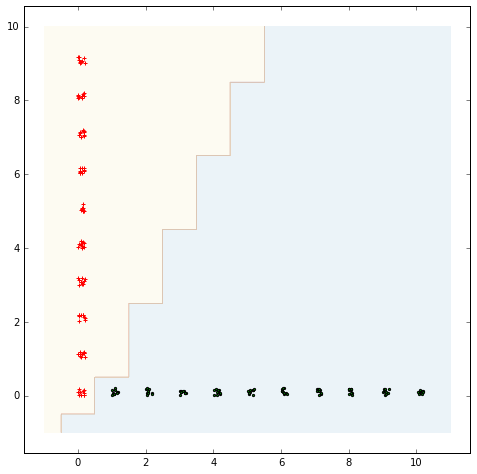

In [5]:
from numpy import genfromtxt
from sklearn.linear_model import LogisticRegression 

lr_clf = LogisticRegression()
D = genfromtxt('dataset1.csv', delimiter=',')

X = D[:, 0:2]
y = D[:, 2]

lr = plot_decision_boundary(lr_clf.predict, X, lr_clf.fit, y)
""" DATASET 1 LOGISTIC REGRESSION """

' DATASET 1 NAIVE BAYES '

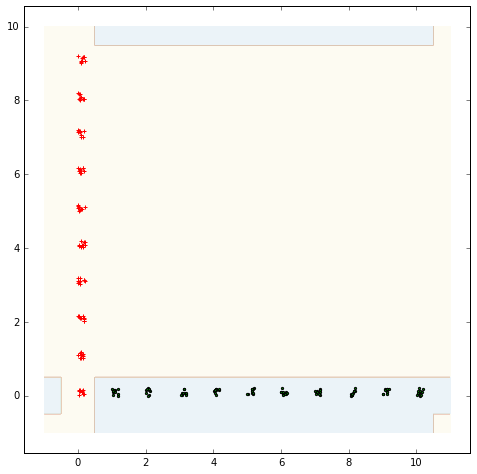

In [6]:
nb_clf = NaiveBayes()
plot_decision_boundary(nb_clf.predict, X, nb_clf.fit, y)
""" DATASET 1 NAIVE BAYES """

In [7]:
f1_ds1_nb = getKFoldf1_scores('dataset1.csv', 5, 'nb_clf')
f1_ds1_lr = getKFoldf1_scores('dataset1.csv', 5, 'lr_clf')

printlist(f1_ds1_nb)
printlist(f1_ds1_lr)

('NB: 1', 1.0)
('NB: 2', 1.0)
('NB: 3', 1.0)
('NB: 4', 1.0)
('NB: 5', 1.0)
('LogReg: 1', 1.0)
('LogReg: 2', 1.0)
('LogReg: 3', 1.0)
('LogReg: 4', 1.0)
('LogReg: 5', 1.0)


For dataset 1, the performance for both models are equivalent. Looking at the logistic regression classifier's decision boundary contours plot, it appears more balanced than Naive Bayes. However, for dataset1-type data (two feature where one or the other is zero and within a small range) and without any preference for precision over recall (or vice-versa) of the model, either one would be fine.

' DATASET 2 NAIVE BAYES '

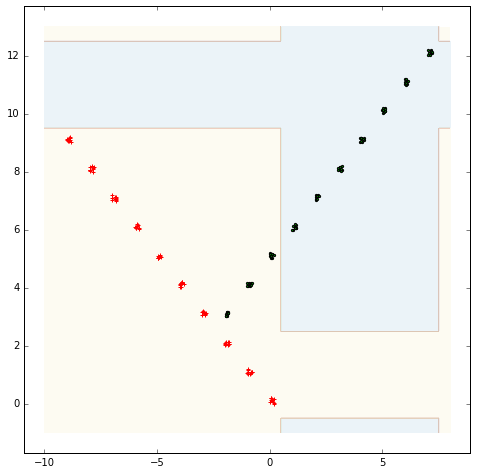

In [8]:
D2 = genfromtxt('dataset2.csv', delimiter=',')

X2 = D2[:, 0:2]
y2 = D2[:, 2]

nb_clf = NaiveBayes()
plot_decision_boundary(nb_clf.predict, X2, nb_clf.fit, y2)
""" DATASET 2 NAIVE BAYES """

' DATASET 2 LOGISTIC REGRESSION '

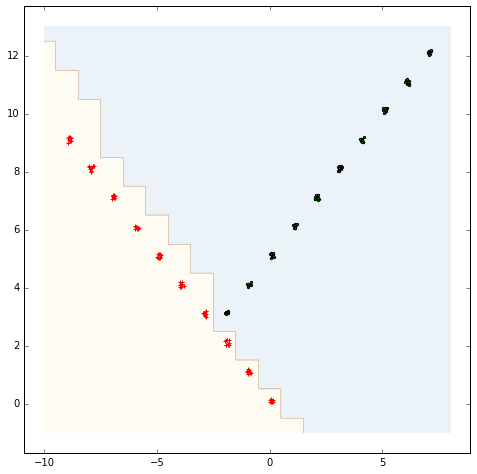

In [9]:
lr_clf = LogisticRegression()
lr = plot_decision_boundary(lr_clf.predict, X2, lr_clf.fit, y2)
""" DATASET 2 LOGISTIC REGRESSION """

In [10]:
f1_ds2_nb = getKFoldf1_scores('dataset2.csv', 5, 'nb_clf')
f1_ds2_lr = getKFoldf1_scores('dataset2.csv', 5, 'lr_clf')

printlist(f1_ds2_nb)
printlist(f1_ds2_lr)

('NB: 1', 0.91666666666666663)
('NB: 2', 0.96153846153846145)
('NB: 3', 0.92682926829268286)
('NB: 4', 0.86274509803921562)
('NB: 5', 0.88888888888888895)
('LogReg: 1', 0.93617021276595747)
('LogReg: 2', 1.0)
('LogReg: 3', 1.0)
('LogReg: 4', 0.95652173913043481)
('LogReg: 5', 0.88888888888888895)


For dataset 2, the logistic regression classifier performs better than the naive bayes model. Looking at the contour boundary plots, each class has a distinct linear pattern. Based on this, the 'shape' of the data, and the performance of each classifier, I would use logistic regression classifier.

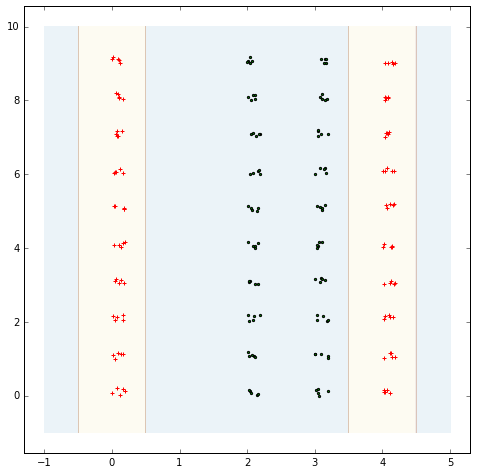

In [11]:
D3 = genfromtxt('dataset3.csv', delimiter=',')

X3 = D3[:, 0:2]
y3 = D3[:, 2]

nb_clf = NaiveBayes()
plot_decision_boundary(nb_clf.predict, X3, nb_clf.fit, y3)

' DATASET 3 LOGISTIC REGRESSION '

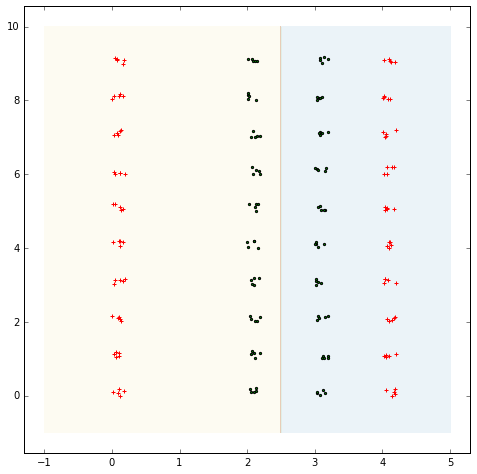

In [12]:
lr_clf = LogisticRegression()
lr = plot_decision_boundary(lr_clf.predict, X3, lr_clf.fit, y3)
""" DATASET 3 LOGISTIC REGRESSION """

In [13]:
f1_ds3_nb = getKFoldf1_scores('dataset3.csv', 5, 'nb_clf')
f1_ds3_lr = getKFoldf1_scores('dataset3.csv', 5, 'lr_clf')

printlist(f1_ds3_nb)
printlist(f1_ds3_lr)

('NB: 1', 1.0)
('NB: 2', 1.0)
('NB: 3', 1.0)
('NB: 4', 1.0)
('NB: 5', 1.0)
('LogReg: 1', 0.47368421052631582)
('LogReg: 2', 0.48780487804878048)
('LogReg: 3', 0.43749999999999994)
('LogReg: 4', 0.52631578947368418)
('LogReg: 5', 0.66666666666666663)


For dataset 3, the naive bayes classifier performs much better than the logistic regression classifier. Again, looking at the plots and the cluster of classes, there is no clear linear boundary. For data of this type, we should use the naive bayes classifier.